In [45]:
import pandas as pd 
import glob
import jsonlines
import json
import re
import logging
from tqdm.auto import tqdm

### Read in Data

In [23]:
all_summary_files = glob.glob('../data/v3_sources/v3_source_summaries/*summaries*')
all_centrality_files = glob.glob('../data/v3_sources/v3_source_summaries/*centrality*')
all_discourse_files = glob.glob('../data/v3_sources/v3_source_summaries/*narrative-keyword*')

In [138]:
def robust_read_jsonlist(f):
    all_lines = []
    for line in open(f, encoding='utf-8'):
        try:
            all_lines.append(json.loads(line))
        except:
            print('error')
    return pd.DataFrame(all_lines, columns=['url', 'response'])


def robust_parse_narr_json_str(t):
    t = t.replace(']','').replace('[','').replace('`', '').strip()
    t2_chunks = re.split(r'\},\s+\{', t)
    
    all_ds = []
    for t2 in t2_chunks:
        d = {}
        t3_chunks = t2.replace('{', '').replace('}', '').strip().split('\n')
        for t3 in t3_chunks:
            for k in keys:
                if 'Name' in t3:
                    d['Name'] = t3.replace('"Name":', '').strip().removeprefix('"').removesuffix('",')
                if 'Narrative Function' in t3:
                    d['Narrative Function'] = t3.replace('"Narrative Function":', '').strip()
        all_ds.append(d)
    return all_ds
    

def robust_extract_json_str(lm_string):
    if not lm_string:
        return None
    # Use regular expressions to search for list brackets across multiple lines
    match = re.search(r'\[.*?\]', lm_string, re.DOTALL)
    if match:
        lm_string = match.group(0)
    try:
        return json.loads(lm_string)
    except:
        try:
            return ast.literal_eval(lm_string)
        except:
            pass
    # logging.error(f"Could not extract json string from: {lm_string}")
    return []

In [139]:
all_summs = []
for f in tqdm(all_summary_files):
    all_summ_df = (
        robust_read_jsonlist(f)
        .assign(source_summaries=lambda df: df['response'].apply(robust_extract_json_str))
    )
    all_summs.append(all_summ_df)

all_discourse = []
for f in tqdm(all_discourse_files):
    all_disc_df = (
        robust_read_jsonlist(f)
        .assign(source_discourse=lambda df: df['response'].apply(robust_parse_narr_json_str))
    )
    all_discourse.append(all_disc_df)

all_centrality = []
for f in tqdm(all_centrality_files):
    all_cent_df = (
        robust_read_jsonlist(f)
        .assign(source_cent=lambda df: df['response'].apply(robust_extract_json_str))
    )
    all_centrality.append(all_cent_df)

  0%|          | 0/489 [00:00<?, ?it/s]

error


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

In [140]:
full_summ_df = pd.concat(all_summs)
full_disc_df = pd.concat(all_discourse)
full_cent_df = pd.concat(all_centrality)

#.loc[lambda df: df['source_summaries'].str.len() == 0].shape

In [340]:
source_summ_df = (
    full_summ_df
        .loc[lambda df: (df['source_summaries'].str.len() < 15) & (df['source_summaries'].str.len() > 3)]
        .drop(columns='response')
        .explode('source_summaries').reset_index(drop=True)
            .pipe(lambda df: pd.concat([
                df[['url']], pd.DataFrame(df['source_summaries'].tolist())
            ], axis=1)
         )
        .drop_duplicates(['url', 'Name'])
)

source_disc_df = (
    full_disc_df
        .drop(columns='response')
        .explode('source_discourse').reset_index(drop=True)
            .pipe(lambda df: pd.concat([
                df[['url']], pd.DataFrame(df['source_discourse'].tolist())
            ], axis=1)
         )
        .drop_duplicates(['url', 'Name'])
)

source_cent_df = (
    full_cent_df
        .drop(columns='response')
        .explode('source_cent')
        .loc[lambda df: df['source_cent'].notnull()]
        .loc[lambda df: df['source_cent'].apply(type) == dict]
        .reset_index(drop=True)
            .pipe(lambda df: pd.concat([
                df[['url']], pd.DataFrame(df['source_cent'].tolist())
            ], axis=1)
         )
        [['url', 'Name', 'Perspective', 'Centrality', 'Is_Error', 'Justification']]
        .dropna()
        .drop_duplicates(['url', 'Name'])
)

In [341]:
source_summ_df.shape

(455274, 4)

In [342]:
source_disc_df.shape

(758619, 3)

In [343]:
source_cent_df.shape

(557556, 6)

In [348]:
full_source_df = (
    source_summ_df
        .merge(source_disc_df, on=['url', 'Name'])
        .merge(source_cent_df, on=['url', 'Name'])
        .loc[lambda df: df['Is_Error'] == 'No']
        # .drop(columns='Note')
)

In [372]:
full_source_df.pipe(lambda df: df['Information'].str.len() < 100).value_counts()

Information
False    358799
True      31688
Name: count, dtype: int64

In [349]:
perp_col_order = [
    'Authoritative',
    'Supportive',
    'Neutral',
    'Against',
    'Skeptical',
    'Informative',  
]
cent_col_order = ['High', 'Medium', 'Low']

In [350]:
full_source_df['Perspective'] = (
    full_source_df['Perspective']
        .apply(lambda x: x if x in to_keep_perp else 'Informative')
)

In [351]:
import seaborn as sns

<Axes: xlabel='Perspective'>

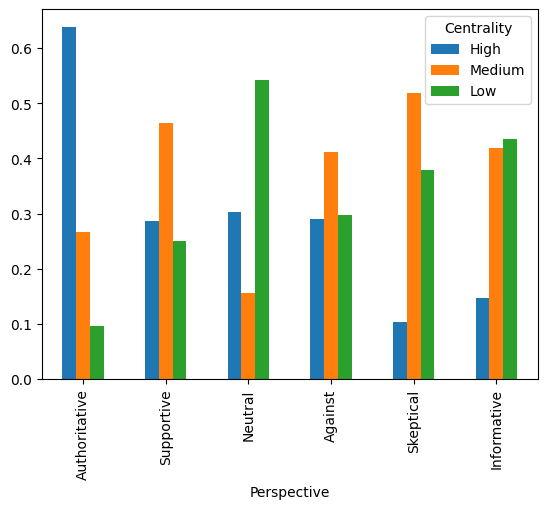

In [352]:
(
    full_source_df[['Perspective', 'Centrality']]
        .value_counts()
        .unstack().loc[perp_col_order, cent_col_order]
        .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
        .plot(kind='bar')
)

In [353]:
different_roles = full_source_df.groupby('Name')[['url', 'Perspective', 'Narrative Function']].aggregate(list)

In [354]:
different_roles.shape

(184927, 3)

In [307]:
t = (different_roles
 .loc[lambda df: df['Perspective'].str.len().pipe(lambda s: (s > 2) & (s < 10))]
)

In [320]:
t['Perspective'].apply(lambda x: list(set(x))).str.len().value_counts()

Perspective
2    6882
3    4186
1    3529
4     890
5     147
6       8
Name: count, dtype: int64

In [322]:
t['Narrative Function']

Name
&pizza                             ["Deal Provider": This source is used to provi...
1-800-FLOWERS.COM                  ["Main Actor": This source is the main actor i...
1-800-Flowers.com                  ["Example": This source is used to provide a s...
19 Republican attorneys general    ["Counterpoint": This source is used to provid...
1Password                          ["Solution": This source is used as an example...
                                                         ...                        
myFICO.com                         ["Authority": This source is used to provide a...
people familiar with the matter    ["Insider": "This source is used to provide ex...
poweroutage.us                     ["Data Source": This source is used to provide...
ulta.com                           ["Authority": This source is used to provide i...
Ángel González                     ["Insight": This source provides expert analys...
Name: Narrative Function, Length: 15642, dtype: object

In [325]:
ls ../make_source_label_hierarchy/embedding_modeling/

batch_label_paired_source_data.py
instruct_emb_model.py
run_emb_trained_model.sh
run_training_for_sentence_similarity_model.sh
train_sentence_similarity_model.py


In [332]:
! scp end:/scratch1/spangher/conditional-information-retrieval/make_source_label_hierarchy/models/mpnet-BASE-all-nli-triplet-to-download/mpnet-trained-model.tar.gz ../make_source_label_hierarchy/embedding_modeling/

mpnet-trained-model.tar.gz                    100%  370MB  18.4MB/s   00:20    


In [355]:
full_source_df.to_csv('../data/v3_sources/v3_combined_sources.csv.gz')

In [356]:
! open .

# Label these sources using GPT4-mini

### Set up GPT4-mini

In [38]:
PROMPT = PROMPT = """
I am trying to determine the role a source plays in this news article, based on the information it provides. 

Choose from these categories:

"Anecdotes, Examples and Illustration"
"Main Actor"
"Subject"
"Background Information"
"Broadening Perspective"
"Analysis"
"Counterpoint"
"Expert"
"Confirmation and Witness"
"Data Resource"
 
Here are definitions for each category:

* "Anecdotes, Examples and Illustration": are real-world stories of every-day people being affected by events in the story.
* "Main Actor": are individuals or entities involved in decision-making that effects events in the story.
* "Subject": are individuals or entities being affected/targeted by events in the story.
* "Background Information": provide broader context to events, helping readers understand the main topic in the context of what is going on and grasp peripheral details.
* "Broadening Perspective": induces the reader to think about the events of the news article in new or bigger picture.
* "Analysis": These sources offer insights and forecasts, often explaining what things mean going forward.
* "Counterpoint": These sources offer diverse perspectives or examples of differences, opposing opinions to provide a more balanced understanding.
* "Expert": These sources provide essential facts, rules or interpretations to help us understanding the events.
* "Confirmation and Witness": Someone whose role is primarily to confirm events that occurred in the news article. 
* "Data Resource": These sources provide statistics and other survey or scientific resources.

Here are some examples of sources with their labels:

ARTICLE TOPIC: "Is Bumble's initial public offering worth the buzz, and can it compete with industry leader Match Group?",
NAME: "Match Group"
BIO: "Match Group is a $45 billion dating conglomerate."
INFO: "Match Group is valued at $46 billion, or roughly eight times Bumble's current valuation."
MY NOTES: "This source provides a look at another company in this industry that gets less buzz"
LABEL: "Counterpoint"

ARTICLE TOPIC: "Will the emerging space travel industry be accessible to the general public or remain a luxury only the super rich can afford?",
NAME: "Ceridwen Dovey",
BIO: "An analyst who trades in the area of space companies."
INFO: "Dovey says that the space barons are shrewdly tapping into our respect for astronauts and our idealism about what space represents."
MY NOTES: "This source peeks behind the curtain to dispel some illusions about how these companies are advertising themselves."
LABEL: "Analysis"

ARTICLE TOPIC: "What is the Biden administration doing to restrict China's access to advanced artificial intelligence technology?"
NAME: "Nvidia",
BIO: "A leading chip developer in the U.S."
INFO: "Nvidia's shares closed down 1.8 percent on Wednesday after reports of the potential export crackdown of it's chips to China."
MY NOTES: "This source shares how they are being impacted by government's moves."
LABEL: "Subject"

Now it's your turn. Respond only with the keyword. Don't say anything else.

ARTICLE TOPIC: {query}
NAME: {source_name}
BIO: {source_bio}
INFO: {source_info}
MY NOTES: {narrative_info}
LABEL:
"""

In [33]:
# ! mv /Users/spangher/Downloads/v3_combined_ALL.json ../data/v3_sources/
import json
import pandas as pd 
queries = json.load(open('../data/v3_sources/v3_combined_ALL.json'))

In [34]:
full_source_df = pd.read_csv('../data/v3_sources/v3_combined_sources.csv.gz', index_col=0)
full_source_df = pd.DataFrame(queries).drop(columns='truth').merge(full_source_df)

In [35]:
full_source_df['Narrative Function'].isnull().value_counts()

Narrative Function
False    386638
True       1500
Name: count, dtype: int64

In [36]:
full_source_df.head(1)#.shape#.head(1)

,url,query,Name,Biography,Information,Narrative Function,Perspective,Centrality,Is_Error,Justification
0,www.cnbc.com/2014/08/07/has-google-lost-contro...,"Is Google's anti-spam algorithm, Penguin, havi...",Josh Bachynski,A consultant who works with companies on searc...,Josh Bachynski stated that not only does Googl...,"""Critic"": This source is used to provide a cri...",Skeptical,Medium,No,Bachynski is a consultant who works with compa...


In [39]:
from tqdm.auto import tqdm
tqdm.pandas()

prompts = full_source_df.assign(
    prompt=lambda df: df.progress_apply(lambda x: PROMPT.format(
        query=x['query'],
        source_name=x['Name'],
        source_bio=x['Biography'],
        source_info=x['Information'],
        narrative_info=x['Narrative Function'].split(':')[-1] if pd.notnull(x['Narrative Function']) else ''
    )
    , axis=1 )
)

  0%|          | 0/388138 [00:00<?, ?it/s]

In [158]:
prompts[['url', 'Name', 'query', 'prompt']].to_csv('cache/quick-discourse-prompts-to-run.csv.gz', compression='gzip')

### Upload to GPT

In [34]:
batch_prompts = (
    prompts
        .drop_duplicates(['url', 'Name'])
        .apply(
            lambda x: {
                "custom_id": x['url'] + '___' + x['Name'], 
                "method": "POST", 
                "url": "/v1/chat/completions", 
                "body": {
                    "model": "gpt-4o-mini",
                    "messages": [{
                        "role": "system", 
                        "content": "You are a helpful journalist's assistant."
                    },{
                        "role": "user", "content": x['prompt']
                    }],"max_tokens": 20
                }}
        , axis=1)
)

In [36]:
import jsonlines
to_upload = []
BATCH_SIZE = 20_000
for i, s in enumerate(tqdm(range(0, len(batch_prompts), BATCH_SIZE))):
    e = s + BATCH_SIZE
    one_batch_df = batch_prompts.iloc[s:e]
    too_long_ids = one_batch_df.str.get('custom_id').str.len().pipe(lambda s: s > 512)
    fname = f'../data/label_discourse/input_data_v3/discourse-batch-{i}.jsonl'
    with jsonlines.open(fname, 'w') as f:
        f.write_all(one_batch_df.loc[lambda s: ~too_long_ids].tolist())
        assert one_batch_df.loc[lambda s: ~too_long_ids].str.get('custom_id').str.len().pipe(lambda s: s > 512).any() == False
    to_upload.append(fname)

  0%|          | 0/20 [00:00<?, ?it/s]

In [40]:
import glob, re
from openai import OpenAI
import os 

os.environ['OPENAI_API_KEY'] = open('/Users/spangher/.openai-isi-project-key.txt').read().strip()
client = OpenAI()
batch_files_on_disk = sorted(glob.glob('../data/label_discourse/input_data_v3/*'), key=lambda x: int(re.search(r'\d+', x)[0]))

In [41]:
batch_file_ids = []
for f in tqdm(batch_files_on_disk):
# for f in tqdm(to_upload):
    batch_input_file = client.files.create(file=open(f, "rb"), purpose="batch")
    batch_file_ids.append(batch_input_file)

  0%|          | 0/20 [00:00<?, ?it/s]

In [43]:
batch_jobs= []
for b_file in tqdm(batch_file_ids):
    batch_input_file_id = b_file.id
    batch_job = client.batches.create(
        input_file_id=batch_input_file_id,
        endpoint="/v1/chat/completions",
        completion_window="24h",
        metadata={
          "description": "nightly eval job"
        }
    )
    batch_jobs.append(batch_job)

  0%|          | 0/20 [00:00<?, ?it/s]

In [50]:
batch_job_ids = list(map(lambda x: x.id, batch_jobs))
batch_statuses = list(map(client.batches.retrieve, batch_job_ids))
completed_batches = (
    pd.DataFrame(list(map(lambda x: x.to_dict(), batch_statuses)))
         .loc[lambda df: df['status'] == 'completed']
         # ['output_file_id'].tolist()
)

In [52]:
mkdir ../data/label_discourse/output_data_v3/

In [53]:
completed_batches['input_file_name'] = completed_batches['input_file_id'].apply(client.files.retrieve).apply(lambda x: x.filename)
for _, (input_file_name, output_id) in tqdm(
    completed_batches[['input_file_name', 'output_file_id']].iterrows(), total=len(completed_batches)
):
    file_response = client.files.content(output_id)
    name, ext = os.path.splitext(input_file_name)
    with open(f'../data/label_discourse/output_data_v3/{name}__output{ext}', 'w') as f:
        f.write(file_response.text)

  0%|          | 0/20 [00:00<?, ?it/s]

### Examine OpenAI Output

In [20]:
import glob, re
import pandas as pd 

files = glob.glob('../data/v3_sources/label_discourse/output_data_v3/discourse-batch-*__output.jsonl')
files = sorted(files, key=lambda x: int(re.search(r'batch-(\d+)', x)[1]))

In [21]:
import jsonlines
import numpy as np 

all_output_items = []
for f in files:#glob.glob('../data/label_discourse/output_data_v3/discourse-batch-*__output.jsonl'):
    output_items = list(jsonlines.open(f))
    all_output_items.extend(output_items)

In [22]:
output_df = pd.DataFrame(all_output_items)
output_df = (
    output_df[['custom_id', 'response']]
         .assign(label=lambda 
                 df: df['response']
                         .str.get('body')
                         .str.get('choices').str.get(0)
                         .str.get('message').str.get('content') 
                         .str.replace('"', '').str.replace('”', '').str.replace('“', '')
                )
         .drop(columns='response')
         .assign(url=lambda df: df['custom_id'].str.split('___').str.get(0))
         .assign(Name=lambda df: df['custom_id'].str.split('___').str.get(1))
         .drop(columns='custom_id')
)

In [24]:
to_keep = set([
    "Anecdotes, Examples and Illustration",
    "Direct Participant",
    "Background Information",
    "Peripheral Context",
    "Analysis",
    "Counterpoint",
    "Expert",
    "Author Perspective",
    "Broadening Perspective",
    "Key Subject",
    "Data Resource",
])

In [25]:
output_df['label'] = output_df['label'].apply(lambda x: x if x in to_keep else np.nan)
# .value_counts()

In [26]:
output_df.head(5)

,label,url,Name
0,Counterpoint,www.cnbc.com/2014/08/07/has-google-lost-contro...,Josh Bachynski
1,Expert,www.cnbc.com/2014/08/07/has-google-lost-contro...,Matt Cutts
2,"Anecdotes, Examples and Illustration",www.cnbc.com/2014/08/07/has-google-lost-contro...,Robert Buehler
3,Expert,www.cnbc.com/2014/08/07/has-google-lost-contro...,Jason Freidenfelds
4,Expert,www.cnbc.com/2014/08/07/has-google-lost-contro...,Eric Enge


### compare with Llama generated sources

In [217]:
llama_files = glob.glob('../data/v3_sources/label_discourse/output_data_v3_llama_v2/*')
llama_files = sorted(llama_files, key=lambda x: int(re.search(r'discourse_labeled__(\d+)', x)[1]))

In [222]:
llama_output = pd.concat(list(map(lambda x: pd.read_json(x, lines=True), llama_files)))
llama_output = (
    llama_output
        .assign(Name= lambda df: df['url'].str.split('__').str.get(1))
        .assign(url=lambda df: df['url'].str.split('__').str.get(0))
        .assign(llama_label=lambda df: df['response'].str.replace('"', '').str.strip().str.split('\n').str.get(0).str.strip())
        .drop(columns='response')
)

In [225]:
to_keep = set([
    'Main Actor',
    'Background Information',
    'Counterpoint',
    'Anecdotes, Examples and Illustration',
    'Expert',
    'Data Resource',
    'Confirmation and Witness',
    'Analysis',
    'Broadening Perspective',
    'Subject'
])

In [227]:
llama_output['llama_label'] = llama_output['llama_label'].apply(lambda x: x if x in to_keep else np.nan) #.value_counts().index.tolist()

In [118]:
m_df = (
    prompts
        [['url', 'query', 'Name', 'Biography', 'Perspective', 'Centrality', 'Information', 'Narrative Function']]
     .merge(output_df)
     .merge(llama_output)
     .rename(columns={
        'label': 'gpt4_label',
        'response': 'llama-3-label'
      })
 # 
)

In [161]:
(m_df
 .assign(gpt4_label=lambda df: 
         df['gpt4_label']
            .replace('Direct Participant', 'Main Actor')
            .replace('Key Subject', 'Subject')
        )
 .pipe(lambda df: df['gpt4_label'] == df['llama_label'])
 .mean()
 # .loc[lambda df: df['gpt4_label'] != df['llama_label']]
 # .sample(100)
 # .to_csv('cache/2024-10-08__discourse-llama-labels-to-annotate-3.csv')
)

0.5725251462621606

#### Accuracy on areas of Disagreement between GPT4 and Llama

In [131]:
import gdown
gdown.download(
    url='https://docs.google.com/spreadsheets/d/1cIBNEDT2qV9EUElBnd1zqppS5aUB5wVK_1q-26sR-9s/edit?usp=sharing',
    output='cache/2024-10-08__discourse-llama-labels-to-annotate-2__hand_annotated.xlsx',
    fuzzy=True
);

Downloading...
From (original): https://drive.google.com/uc?id=1cIBNEDT2qV9EUElBnd1zqppS5aUB5wVK_1q-26sR-9s
From (redirected): https://docs.google.com/spreadsheets/d/1cIBNEDT2qV9EUElBnd1zqppS5aUB5wVK_1q-26sR-9s/export?format=xlsx
To: /Users/spangher/Projects/berkeley-research/conditional-information-retrieval/notebooks/cache/2024-10-08__discourse-llama-labels-to-annotate-2__hand_annotated.xlsx
63.6kB [00:00, 1.57MB/s]


In [136]:
hand_annotated = pd.read_excel('cache/2024-10-08__discourse-llama-labels-to-annotate-2__hand_annotated.xlsx', index_col=0).dropna()

In [139]:
(hand_annotated
 [['llama_label', 'Human Label']]
 .pipe(lambda df: df['llama_label'] == df['Human Label']).mean()
)

0.7906976744186046

In [142]:
(hand_annotated
 # [['llama_label', 'Human Label']]
 .pipe(lambda df: df['gpt4_label'] == df['Human Label'])
 .mean()
)

0.11627906976744186

#### Accuracy on randomly-sampled labeled

In [151]:
gdown.download(
    'https://docs.google.com/spreadsheets/d/1kOQv8VPtGMofsFBRt-QH92Ry9k82zj204FR607MqH0s/edit?usp=sharing',
    output='cache/2024-10-08__discourse-llama-labels-to-annotate-3__annotated.xlsx', 
    fuzzy=True
)

Downloading...
From (original): https://drive.google.com/uc?id=1kOQv8VPtGMofsFBRt-QH92Ry9k82zj204FR607MqH0s
From (redirected): https://docs.google.com/spreadsheets/d/1kOQv8VPtGMofsFBRt-QH92Ry9k82zj204FR607MqH0s/export?format=xlsx
To: /Users/spangher/Projects/berkeley-research/conditional-information-retrieval/notebooks/cache/2024-10-08__discourse-llama-labels-to-annotate-3__annotated.xlsx
67.9kB [00:00, 970kB/s]


'cache/2024-10-08__discourse-llama-labels-to-annotate-3__annotated.xlsx'

In [154]:
annotations = pd.read_excel('cache/2024-10-08__discourse-llama-labels-to-annotate-3__annotated.xlsx', index_col=0)

In [158]:
annotations.dropna().pipe(lambda df: df['llama_label'] == df['Human Label']).mean()

0.8529411764705882

In [144]:
# agreement between GPT4 and llama
(m_df
 [['gpt4-mini-label', 'llama-3-label']]
 .pipe(lambda df: df['gpt4-mini-label'] == df['llama-3-label']).mean()
)

0.64

<Axes: xlabel='llama-3-label', ylabel='gpt4-mini-label'>

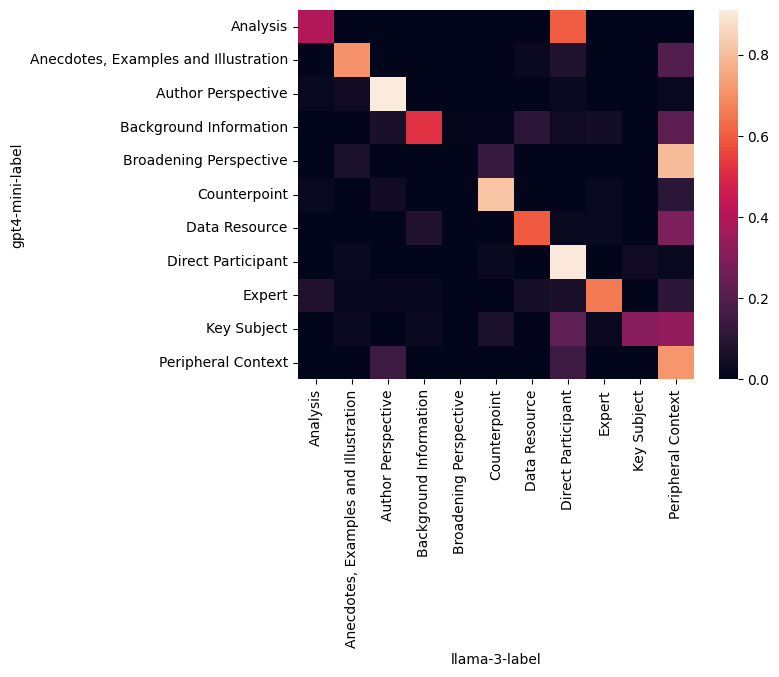

In [152]:
import seaborn as sns 

sns.heatmap(m_df[['gpt4-mini-label', 'llama-3-label']]
 .value_counts()
 .unstack()
 .fillna(0).pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
)

In [136]:
m_df.iloc[21].to_dict()

{'url': 'www.nbcnews.com/business/business-news/more-states-consider-ban-credit-card-surcharges-flna1c8455523',
 'query': 'What are the implications of the recent Visa and MasterCard settlement allowing merchants to impose credit card surcharges, and how will this change affect consumers and the retail industry?',
 'Name': 'Vincent Prieto',
 'Biography': 'New Jersey Assemblyman (D-Secaucus)',
 'Perspective': 'Supportive',
 'Centrality': 'Medium',
 'Information': "Vincent Prieto said he introduced a bill to ban surcharging because it would hit consumers in the pocketbook. 'The amount of the surcharge may seem miniscule on paper, but in the family budget 1.5 to 3 percent could add up to a shorter grocery list or less to spend on gas,' he said in a statement.",
 'Narrative Function': '"Supporting Voice": This source provides a supporting voice to the main narrative, offering a perspective that aligns with the author\'s view."',
 'gpt4-mini-label': 'Counterpoint',
 'llama-3-label': 'Author

In [159]:
import gdown

In [160]:
gdown.download(
    url='https://docs.google.com/spreadsheets/d/1vNip3Yl8gNbmLLV7279sBKc3oDOY2OO9d_IO7x0p1fg/edit?usp=sharing',
    fuzzy=True,
    output='cache/2024-10-08__annotated-llama-gpt-files.xlsx'
)

Downloading...
From (original): https://drive.google.com/uc?id=1vNip3Yl8gNbmLLV7279sBKc3oDOY2OO9d_IO7x0p1fg
From (redirected): https://docs.google.com/spreadsheets/d/1vNip3Yl8gNbmLLV7279sBKc3oDOY2OO9d_IO7x0p1fg/export?format=xlsx
To: /Users/spangher/Projects/berkeley-research/conditional-information-retrieval/notebooks/cache/2024-10-08__annotated-llama-gpt-files.xlsx
111kB [00:00, 1.05MB/s]


'cache/2024-10-08__annotated-llama-gpt-files.xlsx'

In [161]:
annotated_df = pd.read_excel('cache/2024-10-08__annotated-llama-gpt-files.xlsx')

In [167]:
(annotated_df
 .loc[lambda df: df['label'].notnull()]
 # .pipe(lambda df: df['gpt4-mini-label'] == df['label']).mean()
 .pipe(lambda df: df['llama-3-label'] == df['label']).mean()
)

0.6607142857142857

### Finalize output for Yiqin and for the Oracle baseline

In [164]:
combined_sources = json.load(open('../data/v3_sources/v3_combined_ALL.json'))

In [179]:
combined_sources_df = (
    pd.DataFrame(combined_sources)
         .explode('truth').reset_index(drop=True)
         .pipe(lambda df: pd.concat([
             df[['query']], pd.DataFrame(df['truth'].tolist())
         ], axis=1))
)

In [228]:
combined_df_with_oracle_labels = combined_sources_df.merge(llama_output)

In [483]:
combined_df_with_oracle_labels.to_csv('cache/sources-and-queries-with-all-discourse-information.csv.gz', compression='gzip')

In [486]:
# combined_df_with_oracle_labels.head()

In [484]:
! open . 

In [472]:
training_output = (
    combined_df_with_oracle_labels
         # .head(10000)
         # .assign(url_inner=lambda df: df['url'])
         .groupby(['query', 'url'])
         # .apply(lambda df: df.rename(columns={'url_inner': 'url'}).to_dict(orient='records'))
         .apply(lambda df: df.drop(columns='query').to_dict(orient='records'))
         .to_frame('truth')
).reset_index().to_dict(orient='records')

/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_15538/3528981469.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.drop(columns='query').to_dict(orient='records'))


In [474]:
with open('../data/v3_sources/v3_combined_ALL_with_oracle.json', 'w') as f:
    json.dump(training_output, f)

In [232]:
llama_output.to_csv('../data/v3_sources/oracle_labels.csv')

In [481]:
combined_df_with_oracle_labels

,query,url,Name,Biography,Information,Narrative Function,Perspective,Centrality,Is_Error,Justification,Text_embed,llama_label
0,"Is Google's anti-spam algorithm, Penguin, havi...",www.cnbc.com/2014/08/07/has-google-lost-contro...,Josh Bachynski,A consultant who works with companies on searc...,Josh Bachynski stated that not only does Googl...,"""Critic"": This source is used to provide a cri...",Skeptical,Medium,No,Bachynski is a consultant who works with compa...,A consultant who works with companies on searc...,Counterpoint
1,"Is Google's anti-spam algorithm, Penguin, havi...",www.cnbc.com/2014/08/07/has-google-lost-contro...,Matt Cutts,Head of Google's webspam team,Matt Cutts announced the last Penguin update i...,"""Authority"": This source is used to provide an...",Authoritative,Low,No,"Cutts is the head of Google's webspam team, bu...",Head of Google's webspam team: Matt Cutts anno...,Expert
2,"Is Google's anti-spam algorithm, Penguin, havi...",www.cnbc.com/2014/08/07/has-google-lost-contro...,Robert Buehler,"The husband of the owner of Golden Services, a...",Robert Buehler said that his company's traffic...,"""Victim"": This source provides a personal acco...",Supportive,High,No,"Buehler is the owner of Golden Services, a com...","The husband of the owner of Golden Services, a...","Anecdotes, Examples and Illustration"
3,"Is Google's anti-spam algorithm, Penguin, havi...",www.cnbc.com/2014/08/07/has-google-lost-contro...,Jason Freidenfelds,A Google spokesman,Jason Freidenfelds said that Google frequently...,"""Defender"": This source is used to provide a r...",Authoritative,Medium,No,"Freidenfelds is a Google spokesman, providing ...",A Google spokesman: Jason Freidenfelds said th...,Expert
4,"Is Google's anti-spam algorithm, Penguin, havi...",www.cnbc.com/2014/08/07/has-google-lost-contro...,Eric Enge,Head of SEO consultancy Stone Temple Consulting,Eric Enge said that he suspects that there rea...,"""Expert"": This source is used to provide exper...",Skeptical,Medium,No,Enge is an SEO consultant who has worked in th...,Head of SEO consultancy Stone Temple Consultin...,Analysis
...,...,...,...,...,...,...,...,...,...,...,...,...
380133,What led the tech industry to reject a volunta...,slate.com/technology/2015/06/facial-recognitio...,NetChoice,An industry association that represents tech c...,NetChoice opposed an opt-in privacy standard f...,"""Industry Representative"": This source is used...",Against,Medium,No,NetChoice is mentioned as an industry associat...,An industry association that represents tech c...,Main Actor
380134,What led the tech industry to reject a volunta...,slate.com/technology/2015/06/facial-recognitio...,Eric Schmidt,Executive Chairman of Google,Eric Schmidt once said that facial recognition...,"""Authority Figure"": This source is used to pro...",Supportive,Low,No,Eric Schmidt is mentioned as saying that facia...,Executive Chairman of Google: Eric Schmidt onc...,Expert
380135,What led the tech industry to reject a volunta...,slate.com/technology/2015/06/facial-recognitio...,Jay Rockefeller,A former US Senator who proposed a bill to rei...,Jay Rockefeller proposed a bill to rein in dat...,"""Legislative Example"": This source is used to ...",Supportive,Low,No,Jay Rockefeller is mentioned as sponsoring a b...,A former US Senator who proposed a bill to rei...,"Anecdotes, Examples and Illustration"
380136,What led the tech industry to reject a volunta...,slate.com/technology/2015/06/facial-recognitio...,Congress,The legislative branch of the US government,"Congress passed the USA Freedom Act in 2015, w...","""Regulatory Body"": This source is used to repr...",Neutral,High,No,Congress is mentioned as passing the USA Freed...,The legislative branch of the US government: C...,Main Actor


In [251]:
(combined_df_with_oracle_labels
 .value_counts(['llama_label', 'Centrality'])
 .unstack()[['High', 'Medium', 'Low']]
 .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
 .sort_values('High', ascending=False)
 .round(2).index.tolist()
)

['Main Actor',
 'Analysis',
 'Background Information',
 'Subject',
 'Expert',
 'Data Resource',
 'Confirmation and Witness',
 'Anecdotes, Examples and Illustration',
 'Counterpoint',
 'Broadening Perspective']

# Analyze Predictability of Scores

In [511]:
from sklearn.cluster import HDBSCAN, KMeans

### Dataset setup

In [306]:
label_distributions = (
    llama_output[['url', 'llama_label']]
         .value_counts().unstack()
         .fillna(0)
         .pipe(lambda df: df.divide(df.sum(axis=1),axis=0))
)

In [316]:
query_label_dists = label_distributions.merge(
    prompts[['url', 'query']].drop_duplicates(), 
    left_index=True, 
    right_on='url'
)

In [319]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

/Users/spangher/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(3, 384)


In [324]:
from sklearn.metrics.pairwise import cosine_similarity

In [371]:
col_dist = [
    'Analysis',
    'Anecdotes, Examples and Illustration',
    'Background Information',
    'Broadening Perspective',
    'Confirmation and Witness',
    'Counterpoint',
    'Data Resource',
    'Expert',
    'Main Actor',
    'Subject'
]

bootstraps = []
for _ in tqdm(range(10)):
    sample_queries_labels = query_label_dists.sample(5_000)
    query_embeddings = model.encode(sample_queries_labels['query'].tolist())
    query_cos_sim = cosine_similarity(query_embeddings)
    label_dist_sim = cosine_similarity(sample_queries_labels[col_dist])

    label_dist_unstack = pd.DataFrame(label_dist_sim).unstack()
    query_dist_unstack = pd.DataFrame(query_cos_sim).unstack()
    concat_dists = pd.concat([
        label_dist_unstack.to_frame('label_sim'),
        query_dist_unstack.to_frame('query_sim')
    ], axis=1).reset_index()
    concat_dists = concat_dists.loc[lambda df: df['level_0'] != df['level_1']].drop(columns=['level_0', 'level_1'])
    
    c = concat_dists.corr()
    bootstraps.append(c)

  0%|          | 0/10 [00:00<?, ?it/s]

In [376]:
np.mean(list(map(lambda x: x.iloc[0].iloc[1], bootstraps)))

0.10855434445261684

In [378]:
query_label_dists.to_csv('cache/cluster-prediction-data__label-dists.csv.gz', compression='gzip')

### Try clustering with HDBSCAN

In [542]:
from sklearn.cluster import HDBSCAN

In [548]:
# scan = HDBSCAN()
# learned_clusters = scan.fit_predict(label_distributions, )

In [ ]:
# pd.Series(learned_clusters).value_counts()
def kl_divergence(p, q):
    return entropy(p, q)

N = len(label_distributions)
data = label_distributions.values
distance_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(i+1, N):
        distance = kl_divergence(data[i], data[j])
        distance_matrix[i, j] = distance_matrix[j, i] = distance

# Step 2: Hierarchical clustering
clustering = AgglomerativeClustering(
    affinity='precomputed',
    linkage='average',
    distance_threshold=0,
    n_clusters=None
)
clustering.fit(distance_matrix)

In [ ]:
labels = clustering.labels_
score = silhouette_score(distance_matrix, labels, metric='precomputed')
print(f'Silhouette Score: {score}')

### Try Clustering with Dirichlet Mixtures

In [13]:
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.distributions.constraints as constraints

# Set random seed for reproducibility
pyro.set_rng_seed(0)

# Generate synthetic data for demonstration purposes
def generate_dirichlet_data(N, alpha):
    return np.random.dirichlet(alpha, N)

# Define the Pyro model
def model(data):
    with pyro.plate('components', K):
        # Corrected: Use .to_event(1) to specify that last dimension is event dimension
        alpha_k = pyro.sample('alpha_k', dist.Gamma(torch.tensor(2.0), torch.tensor(1.0)).expand([D]).to_event(1))
    
    # Prior for mixture weights (cluster probabilities)
    pi = pyro.sample('pi', dist.Dirichlet(torch.ones(K)))
    
    with pyro.plate('data', len(data)):
        # Categorical distribution for cluster assignments
        z = pyro.sample('z', dist.Categorical(pi))
        
        # Select the alpha parameters corresponding to the assigned cluster
        alpha_z = alpha_k[z]
        
        # Likelihood: data follows a Dirichlet distribution with parameters alpha_z
        pyro.sample('obs', dist.Dirichlet(alpha_z), obs=data)

# Define the guide (variational distribution)
def guide(data):
    # Variational parameters for alpha_k
    alpha_k_q = pyro.param('alpha_k_q', torch.rand(K, D) + 1.0, constraint=constraints.positive)
    
    # Variational parameters for pi
    pi_q = pyro.param('pi_q', torch.ones(K), constraint=constraints.simplex)
    
    with pyro.plate('components', K):
        # Corrected: Use .to_event(1) to match the event dimensions in the model
        pyro.sample('alpha_k', dist.Gamma(alpha_k_q, torch.tensor(1.0)).to_event(1))
    
    # Variational distribution for pi
    pyro.sample('pi', dist.Dirichlet(pi_q))
    
    # Variational distribution for z
    with pyro.plate('data', len(data)):
        q_z_probs = pyro.param('q_z_probs', torch.ones(len(data), K) / K, constraint=constraints.simplex)
        pyro.sample('z', dist.Categorical(q_z_probs))

# Optimizer
optimizer = Adam({'lr': 0.01})

# Loss function (Evidence Lower Bound)
elbo = Trace_ELBO()

# Stochastic Variational Inference (SVI) object
svi = SVI(model, guide, optimizer, loss=elbo)

In [ ]:
# Create sample data from two Dirichlet distributions
N = 500  # Total number of data points
alpha1 = np.array([5, 1, 1])  # Parameters for the first Dirichlet distribution
alpha2 = np.array([1, 5, 1])  # Parameters for the second Dirichlet distribution

# Generate data
X1 = generate_dirichlet_data(N // 2, alpha1)
X2 = generate_dirichlet_data(N // 2, alpha2)
X = np.vstack((X1, X2))  # Combine the data
np.random.shuffle(X)  # Shuffle the data

# Convert data to PyTorch tensor
X = torch.tensor(X, dtype=torch.float)

# Number of clusters
K = 10

# Dimensionality of the Dirichlet distribution
D = X.shape[1]

# Training loop
num_iterations = 5000
for step in range(num_iterations):
    loss = svi.step(X)
    if step % 500 == 0:
        print(f"Step {step} - ELBO Loss: {loss:.4f}")

# Retrieve learned parameters
alpha_k_map = pyro.param('alpha_k_q').detach().numpy()
pi_map = pyro.param('pi_q').detach().numpy()
q_z_probs = pyro.param('q_z_probs').detach().numpy()

# Normalize pi_map to sum to 1
pi_map /= np.sum(pi_map)

# Display the estimated parameters
print("\nEstimated mixture weights (pi):", pi_map)
print("Estimated Dirichlet parameters (alpha_k):\n", alpha_k_map)

# Assign clusters based on the highest posterior probability
cluster_assignments = np.argmax(q_z_probs, axis=1)

### Cluster with KMeans

In [1]:
import pandas as pd 
import json
orig_train_df = pd.DataFrame(json.load(open('../data/v3_sources/v3_combined_TRAIN.json')))
orig_test_df = pd.DataFrame(json.load(open('../data/v3_sources/v3_combined_TEST.json')))
train_test_mapper = pd.concat([
    orig_train_df[['url']].assign(split='train'),
    orig_test_df[['url']].assign(split='test')
])

In [539]:
clustering = KMeans(n_clusters=5)
clusters = clustering.fit_predict(label_distributions, )

In [540]:
(pd.DataFrame(
    clustering.cluster_centers_, 
    columns=label_distributions.columns.tolist(),
 )
 .round(2)
 .pipe(lambda df: (df * 100).astype(int).astype(str) + '%')
 .loc[[0, 1, 3]]
)

,Analysis,"Anecdotes, Examples and Illustration",Background Information,Broadening Perspective,Confirmation and Witness,Counterpoint,Data Resource,Expert,Main Actor,Subject
0,6%,3%,19%,1%,6%,7%,4%,4%,48%,1%
1,8%,5%,30%,2%,5%,22%,5%,6%,16%,1%
3,6%,43%,12%,2%,4%,7%,7%,9%,10%,1%


Text(0, 0.5, 'Proportion of Each Label')

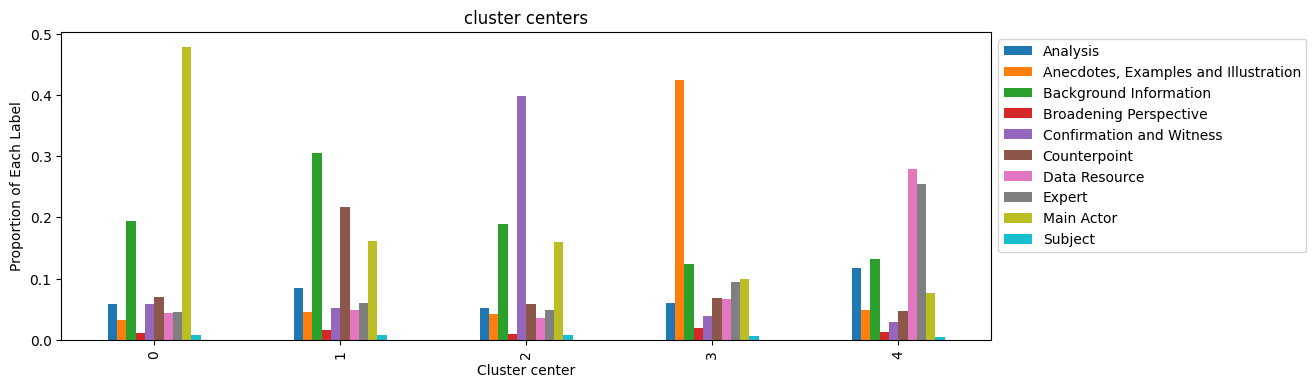

In [541]:
import matplotlib.pyplot as plt
pd.DataFrame(
    clustering.cluster_centers_, 
    columns=label_distributions.columns
).plot(kind='bar', figsize=(12,4), title='cluster centers')

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Cluster center')
plt.ylabel('Proportion of Each Label')

In [ ]:
# q: XXX 
# -> Predict: This belongs to cluster 3
#     -> ~60% of it's sources are anecdotes
#     -> what next?
# During interleaving:
#      prompt: Articles like this tend to use "Anecdotes" followed by "Author perspective"
#      prompt: Articles like this tend to use .6 "Anecodes", .2 "Author perspective"....
#               Generate the list of discourse roles you want to use 
#                  ->

In [40]:
t2 = (
    label_distributions
         .merge(prompts[['url', 'query']].drop_duplicates(), 
                right_on='url', 
                left_index=True
               ).drop_duplicates(['url', 'query'])
)

In [60]:
q = t2.loc[lambda df: df['clusters'] == 3]['query'].iloc[10]
q

"What is the scope of celebrity involvement in the Flint water crisis relief efforts, particularly in the wake of Beyoncé's recent Super Bowl performance and tour announcement?"

In [61]:
output_with_queries.loc[lambda df: df['query'] == q]

,label,url,Name,query,Biography
52688,Author Perspective,admin.alternet.org/environment/michigan-beyonc...,Lorraine Chow,What is the scope of celebrity involvement in ...,A freelance writer and reporter based in South...
52689,Background Information,admin.alternet.org/environment/michigan-beyonc...,Live Nation,What is the scope of celebrity involvement in ...,Beyonce's tour promoter
52690,Background Information,admin.alternet.org/environment/michigan-beyonc...,MLive.com,What is the scope of celebrity involvement in ...,A news website
52691,"Anecdotes, Examples and Illustration",admin.alternet.org/environment/michigan-beyonc...,Big Sean,What is the scope of celebrity involvement in ...,A rapper and Detroit native
52692,"Anecdotes, Examples and Illustration",admin.alternet.org/environment/michigan-beyonc...,Mark Wahlberg and Sean 'Diddy' Combs,What is the scope of celebrity involvement in ...,An actor and a hip-hop entertainer
52693,"Anecdotes, Examples and Illustration",admin.alternet.org/environment/michigan-beyonc...,Cher,What is the scope of celebrity involvement in ...,A singer


### train cluster prediction

In [564]:
query_label_dists = (
    query_label_dists
         # .drop(columns='Unnamed: 0')
         .merge(train_test_mapper)
)

In [529]:
query_label_dists.to_csv('cache/cluster-prediction-data__label-dists.csv.gz', compression='gzip')

#### train and evaluate

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import pandas as pd 
import numpy as np 
from datasets import Dataset, DatasetDict
import evaluate
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer, TrainingArguments, Trainer
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['WANDB_DISABLED'] = 'true'

col_dist = [
    'Analysis',
    'Anecdotes, Examples and Illustration',
    'Background Information',
    'Broadening Perspective',
    'Confirmation and Witness',
    'Counterpoint',
    'Data Resource',
    'Expert',
    'Main Actor',
    'Subject'
]

PREDICT_NUM_SOURCES = True
PREDICT_CLUSTER_DISTRIBUTION = False

try:
    query_label_dists = pd.read_csv('cache/cluster-prediction-data__label-dists.csv.gz')
except:
    query_label_dists = pd.read_csv('cluster-prediction-data__label-dists.csv.gz')

if 'Unnamed: 0' in query_label_dists.columns:
    query_label_dists = query_label_dists.drop(columns='Unnamed: 0')

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

model_name = "distilbert/distilbert-base-uncased"
# model_name = "t5-base"
# model_name = "albert-xxlarge-v2"
for n_clusters in [8]: # range(4, 5):
    if PREDICT_CLUSTER_DISTRIBUTION:
        print(f'CLUSTERING WITH {n_clusters}')
        clustering = KMeans(n_clusters=n_clusters)
        clusters = clustering.fit_predict(query_label_dists[col_dist])
        cluster_prediction_data = query_label_dists[['url', 'query', 'split']].assign(label=clusters)
        train_df = cluster_prediction_data.loc[lambda df: df['split'] == 'train']
        test_df = cluster_prediction_data.loc[lambda df: df['split'] == 'test']
        distinct_labels = sorted(train_df['label'].unique())
        n_labels = len(distinct_labels)
    else:
        train_df = orig_train_df.copy()
        train_df['label'] = train_df['truth'].str.len()
        test_df = orig_test_df.copy()
        test_df['label'] = test_df['truth'].str.len()
        n_labels = 1

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=n_labels,
        # id2label=int2label_mapper, label2id=label2int_mapper
    )
    # model.config.problem_type = "regression"
    
    def preprocess_function(examples):
        output_dict = tokenizer(examples["query"], truncation=True)
        return output_dict
    
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        return f1.compute(predictions=predictions, references=labels, average='macro')
    
    ds = DatasetDict()
    ds['train'] = Dataset.from_pandas(train_df.dropna())#.sample(50_000))
    ds['test'] =  Dataset.from_pandas(test_df.dropna())#.sample(10_000))
    tokenized_ds = ds.map(preprocess_function, batched=True, num_proc=10)
    training_args = TrainingArguments(
        output_dir="cache/cluster-label-model" if PREDICT_CLUSTER_DISTRIBUTION else 'cache/regression-label-model',
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()

hyperparameter sweep:
2: 0.74
3: 0.57
4: 0.49
5: 0.43
6: 0.38
7: 0.36
8: 0.35
9: 0.29

### Try Label Length Prediction

In [18]:
from sklearn.linear_model import PoissonRegressor, LinearRegression
from sentence_transformers import SentenceTransformer

In [12]:
emb_model = SentenceTransformer("all-MiniLM-L6-v2")

In [13]:
y_train = orig_train_df['truth'].str.len()
y_test = orig_test_df['truth'].str.len()
X_train = orig_train_df['query']
X_test = orig_test_df['query']

In [19]:
reg = PoissonRegressor()
reg = LinearRegression()

In [14]:
embeddings_train = model.encode(X_train.tolist(), show_progress_bar=True)
embeddings_test = model.encode(X_test.tolist(), show_progress_bar=True)

Batches:   0%|          | 0/1285 [00:00<?, ?it/s]

Batches:   0%|          | 0/322 [00:00<?, ?it/s]

In [20]:
reg.fit(embeddings_train, y_train)

LinearRegression()

In [22]:
y_pred = reg.predict(embeddings_test)

In [27]:
pd.concat([
    pd.Series(y_pred).to_frame('y_pred'),
    y_test.to_frame('y_test')
], axis=1).corr()

,y_pred,y_test
y_pred,1.000000,0.298946
y_test,0.298946,1.000000


In [181]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

class MLP_PoissonRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(MLP_PoissonRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Exponential activation to ensure non-negative output
        x = F.relu(self.fc3(x))
        output = torch.exp(self.fc4(x))
        return output

def generate_data(num_samples, input_dim):
    """Generates synthetic Poisson regression data."""
    X = torch.randn(num_samples, input_dim)
    true_weights = torch.randn(input_dim, 1)  # Random weights for targets
    rates = torch.exp(X @ true_weights)  # True rate parameter (λ)
    y = torch.poisson(rates)  # Generate Poisson-distributed target values
    return X, y

def train_model(model, train_loader, optimizer, loss_fn, epochs):
    """Trains the model and prints the average loss for each epoch."""
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Reset gradients
            y_pred = model(X_batch)  # Forward pass
            loss = loss_fn(y_pred, y_batch)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            total_loss += loss.item() * X_batch.size(0)  # Accumulate loss

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

def evaluate_model(model, data_loader, metric="mse"):
    """Evaluates the model using the chosen metric: 'mse' or 'poisson_deviance'."""
    model.eval()  # Set the model to evaluation mode
    total_metric = 0.0

    with torch.no_grad():  # No gradient calculation during evaluation
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)  # Forward pass
            if metric == "mse":
                metric_value = torch.mean((y_pred - y_batch) ** 2).item()
            elif metric == "poisson_deviance":
                # Poisson deviance calculation
                metric_value = torch.mean(
                    y_pred - y_batch * torch.log(y_pred + 1e-8)
                ).item()
            total_metric += metric_value * X_batch.size(0)

    avg_metric = total_metric / len(data_loader.dataset)
    print(f"Evaluation - {metric.upper()}: {avg_metric:.4f}")
    return avg_metric

# Hyperparameters
input_dim = 384
hidden_dim = 120
batch_size = 32
epochs = 20
learning_rate = 2e-5

train_X_tens = torch.tensor(embeddings_train)
train_y_tens = torch.tensor(y_train.to_frame().values)

val_X_tens = torch.tensor(embeddings_test)
val_y_tens = torch.tensor(y_test.to_frame().values)

# Create DataLoaders for training and validation
train_dataset = TensorDataset(train_X_tens, train_y_tens)
val_dataset = TensorDataset(val_X_tens, val_y_tens)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
model = MLP_PoissonRegression(input_dim, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.PoissonNLLLoss(log_input=False)

# Train the model
train_model(model, train_loader, optimizer, loss_fn, epochs)

# Evaluate the model using both MSE and Poisson Deviance metrics
print("\nEvaluating the model...")
evaluate_model(model, val_loader, metric="mse")
evaluate_model(model, val_loader, metric="poisson_deviance")

Epoch [1/20], Loss: -3.3875
Epoch [2/20], Loss: -7.2131
Epoch [3/20], Loss: -7.3549
Epoch [4/20], Loss: -7.4129
Epoch [5/20], Loss: -7.4424
Epoch [6/20], Loss: -7.4602
Epoch [7/20], Loss: -7.4724
Epoch [8/20], Loss: -7.4808
Epoch [9/20], Loss: -7.4873
Epoch [10/20], Loss: -7.4927
Epoch [11/20], Loss: -7.4968
Epoch [12/20], Loss: -7.5006
Epoch [13/20], Loss: -7.5037
Epoch [14/20], Loss: -7.5072
Epoch [15/20], Loss: -7.5096
Epoch [16/20], Loss: -7.5121
Epoch [17/20], Loss: -7.5148
Epoch [18/20], Loss: -7.5170
Epoch [19/20], Loss: -7.5190
Epoch [20/20], Loss: -7.5211

Evaluating the model...
Evaluation - MSE: 10.9453
Evaluation - POISSON_DEVIANCE: -7.4434


-7.443393172178751

In [182]:
y_pred = model(val_X_tens)

In [ ]:
# y_pred
# torch.poisson(y_pred)

In [196]:
test_df = (
    pd
     # .DataFrame(torch.poisson(y_pred).detach().numpy(), columns=['y_pred'])
     .DataFrame(y_pred.detach().numpy(), columns=['y_pred'])
     .assign(y_test=y_test)
)

In [199]:
import matplotlib.pyplot as plt 

In [ ]:
test_df['y_test'].min()
test_df['y_test'].max()

test_df['y_pred'].min()
test_df['y_pred'].max() 


In [219]:
def scale_predictions_min_max(y_pred, y_obs):
    """Min-Max scaling of predictions to match observed data range."""
    y_pred_min, y_pred_max = y_pred.min(), y_pred.max()
    y_obs_min, y_obs_max = y_obs.min(), y_obs.max()
    
    # Apply Min-Max scaling
    y_pred_scaled = (y_pred - y_pred_min) / (y_pred_max - y_pred_min)
    y_pred_scaled = y_pred_scaled * (y_obs_max - y_obs_min) + y_obs_min
    return y_pred_scaled

In [229]:
(orig_test_df
 .assign(y_pred=scale_predictions_min_max(test_df['y_pred'], test_df['y_test']).astype(int))
 .to_json('../data/results/poisson_regression.jsonl', lines=True, orient='records')
)

In [231]:
! open ../data/results/

In [224]:
test_df.assign(y_pred=scale_predictions_min_max(test_df['y_pred'], test_df['y_test']).astype(int)).corr(method='spearman')

,y_pred,y_test
y_pred,1.000000,0.316986
y_test,0.316986,1.000000


Text(0, 0.5, 'Predicted # Examples')

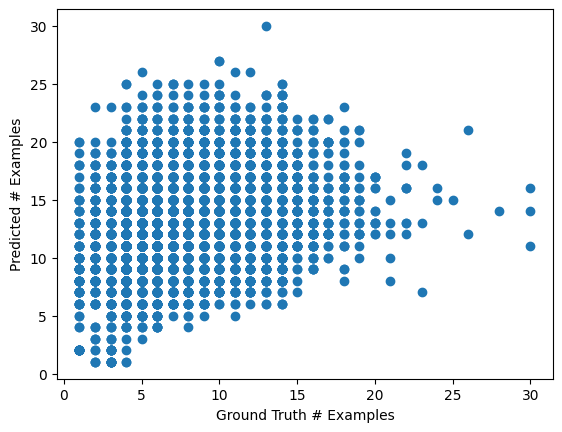

In [225]:
plt.scatter(test_df['y_test'], scale_predictions_min_max(test_df['y_pred'], test_df['y_test']).astype(int))
plt.xlabel('Ground Truth # Examples')
plt.ylabel('Predicted # Examples')

#### Bert Regression Model

In [116]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset

class BertPoissonRegression(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", hidden_dim=128):
        super(BertPoissonRegression, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.3)  # Regularization
        self.fc1 = nn.Linear(self.bert.config.hidden_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, input_ids, attention_mask):
        # Extract embeddings from BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [CLS] token embedding

        # Pass through a small MLP for regression
        x = self.dropout(pooled_output)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        # Apply exponential to ensure non-negative Poisson rate output
        return torch.exp(x)

def train_model(model, train_loader, optimizer, loss_fn, epochs):
    """Trains the model and prints the average loss for each epoch."""
    model.train()
    for epoch in tqdm(range(epochs)):
        total_loss = 0.0
        for batch in tqdm(train_loader):
            input_ids, attention_mask, y_batch = batch
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(input_ids, attention_mask)

            # Compute loss
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * input_ids.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

def evaluate_model(model, data_loader, metric="mse"):
    """Evaluates the model using MSE or Poisson Deviance."""
    model.eval()
    total_metric = 0.0

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, y_batch = batch
            y_pred = model(input_ids, attention_mask)

            if metric == "mse":
                metric_value = torch.mean((y_pred - y_batch) ** 2).item()
            elif metric == "poisson_deviance":
                metric_value = torch.mean(y_pred - y_batch * torch.log(y_pred + 1e-8)).item()

            total_metric += metric_value * input_ids.size(0)

    avg_metric = total_metric / len(data_loader.dataset)
    print(f"Evaluation - {metric.upper()}: {avg_metric:.4f}")
    return avg_metric

In [ ]:
def process_text_data(texts, y, tokenizer, seq_length=512):
    """Generates dummy text data and Poisson targets."""
    encodings = tokenizer(texts, padding=True, truncation=True, max_length=seq_length, return_tensors="pt")

    # Random weights for generating Poisson targets
    # true_weights = torch.randn(encodings["input_ids"].size(1), 1)
    # rates = torch.exp(encodings["input_ids"].float() @ true_weights)  # Rate parameter λ
    # y = torch.poisson(rates)  # Poisson-distributed targets
    y = torch.tensor(y)
    return encodings, y

In [118]:
import pandas as pd 
import json
train_df = pd.DataFrame(json.load(open('../data/v3_sources/v3_combined_TRAIN.json')))
train_df['label'] = train_df['truth'].str.len()
test_df = pd.DataFrame(json.load(open('../data/v3_sources/v3_combined_TEST.json')))
test_df['label'] = test_df['truth'].str.len()

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings, train_y = process_text_data(train_df['query'].tolist(), train_df['label'].tolist(), tokenizer=tokenizer)
test_encodings, test_y = process_text_data(test_df['query'].tolist(), test_df['label'].tolist(), tokenizer=tokenizer)

# Hyperparameters
batch_size = 8
epochs = 3
learning_rate = 2e-5

# Initialize tokenizer and model
model = BertPoissonRegression()

# Create DataLoaders
train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_y)
val_dataset = TensorDataset(val_encodings["input_ids"], val_encodings["attention_mask"], val_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Optimizer and Loss Function
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.PoissonNLLLoss(log_input=False)

# Train the model
print("Training the model...")
train_model(model, train_loader, optimizer, loss_fn, epochs)

# Evaluate the model
print("\nEvaluating the model...")
evaluate_model(model, val_loader, metric="mse")
evaluate_model(model, val_loader, metric="poisson_deviance")

### Evaluate Clusters

In [551]:
import pickle

In [603]:
with open('../data/v3_clusters/pred_results.pkl', 'rb') as f:
    prediction_results = pickle.load(f)
    
with open('../data/v3_clusters/clusterer.pkl', 'rb') as f:
    clusterer = pickle.load(f)

In [614]:
import warnings
import pandas as pd
pd.options.mode.chained_assignment = None 

In [615]:
to_label_test_df = query_label_dists.loc[lambda df: df['split'] == 'test']
to_label_test_df[['cluster_pred_1', 'cluster_pred_2', 'cluster_pred_3']] = np.argsort(-prediction_results.predictions)[:, :3]

true_clusters = pd.Series(clusterer.predict(to_label_test_df[col_dist]))
to_label_test_df = (
    to_label_test_df
         .drop(columns=col_dist)
         .assign(true_cluster=true_clusters.values)
)

In [622]:
(
    to_label_test_df
         .pipe(
             lambda df: 
               (df['true_cluster'] == df['cluster_pred_1']) | 
               (df['true_cluster'] == df['cluster_pred_2']) | 
               (df['true_cluster'] == df['cluster_pred_3'])
              )
         .mean()
)

0.7082238442822384

In [638]:
to_label_test_df.to_csv('../data/v3_clusters/data_cluster_assignment.csv')

In [669]:
to_label_test_df.head(2)

,url,query,split,cluster_pred_1,cluster_pred_2,cluster_pred_3,true_cluster
1,947freshfm.cbslocal.com/2013/04/29/vampire-wee...,What's behind the unexpected collaboration bet...,test,3,1,5,3
2,947thewave.cbslocal.com/2015/05/04/celebrate-c...,What kind of deals and freebies can consumers ...,test,0,6,3,0


In [670]:
for i in range(1, 4):
    to_label_test_df[['url', f'cluster_pred_{i}']]

In [691]:
from scipy.stats import entropy

In [732]:
pred_cols = list(map(lambda x: f'{x}__cluster_pred', col_dist))
true_cols = list(map(lambda x: f'{x}__gold_dist', col_dist))
kl_div_1 = (
    to_label_test_df
        [['url', f'cluster_pred_1']]
         .merge(cluster_centers, left_on='cluster_pred_1', right_index=True)
         .rename(columns={k: v for k, v in zip(col_dist, pred_cols)})
         .merge(label_distributions, right_index=True, left_on='url')
         .rename(columns={k: v for k, v in zip(col_dist, true_cols)})
         .apply(lambda x: entropy(x[true_cols].astype(float), x[pred_cols].astype(float)), axis=1)
)

In [762]:
t = (
    to_label_test_df
        [['url', f'cluster_pred_1']]
         .merge(cluster_centers, left_on='cluster_pred_1', right_index=True)
         .rename(columns={k: v for k, v in zip(col_dist, pred_cols)})
         .merge(label_distributions, right_index=True, left_on='url')
         .rename(columns={k: v for k, v in zip(col_dist, true_cols)})
.iloc[3]
)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Analysis'),
  Text(1, 0, 'Anecdotes, Examples and Illustration'),
  Text(2, 0, 'Background Information'),
  Text(3, 0, 'Broadening Perspective'),
  Text(4, 0, 'Confirmation and Witness'),
  Text(5, 0, 'Counterpoint'),
  Text(6, 0, 'Data Resource'),
  Text(7, 0, 'Expert'),
  Text(8, 0, 'Main Actor'),
  Text(9, 0, 'Subject')])

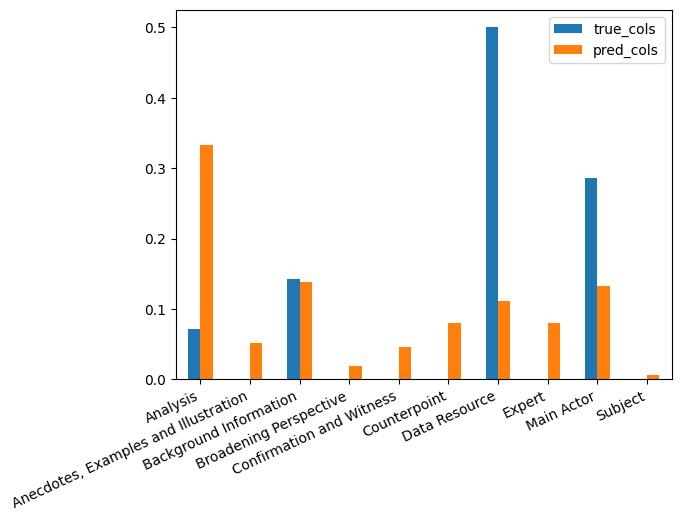

In [763]:
pd.concat([
    t[true_cols].to_frame('true_cols').rename(index={k:v for k,v in zip(true_cols, col_dist)}),
    t[pred_cols].to_frame('pred_cols').rename(index={k:v for k,v in zip(pred_cols, col_dist)}),    
], axis=1).plot(kind='bar')
plt.xticks(rotation=25, horizontalalignment='right')

In [728]:
kl_div_2 = (((    to_label_test_df
       .set_index('url')
        [['cluster_pred_1']]
         .merge(cluster_centers, left_on='cluster_pred_1', right_index=True,how='left')
)[col_dist] 
 + (
    to_label_test_df
     .set_index('url')
        [['cluster_pred_2']]
         .merge(cluster_centers, left_on='cluster_pred_2', right_index=True, how='left')
)[col_dist])
 .pipe(lambda df: df / 2)
  .rename(columns={k: v for k, v in zip(col_dist, pred_cols)})
  .merge(label_distributions, right_index=True, left_index=True)
  .rename(columns={k: v for k, v in zip(col_dist, true_cols)})
  .apply(lambda x: entropy(x[true_cols].astype(float), x[pred_cols].astype(float)), axis=1)
)

In [729]:
kl_div_3 = (((
    to_label_test_df
       .set_index('url')
        [['cluster_pred_1']]
         .merge(cluster_centers, left_on='cluster_pred_1', right_index=True,how='left')
    )[col_dist] 
     + (
    to_label_test_df
     .set_index('url')
        [['cluster_pred_2']]
         .merge(cluster_centers, left_on='cluster_pred_2', right_index=True, how='left')
    )[col_dist]
     + (
    to_label_test_df
     .set_index('url')
        [['cluster_pred_3']]
         .merge(cluster_centers, left_on='cluster_pred_3', right_index=True, how='left')
    )[col_dist]             
)
  .pipe(lambda df: df / 3)
  .rename(columns={k: v for k, v in zip(col_dist, pred_cols)})
  .merge(label_distributions, right_index=True, left_index=True)
  .rename(columns={k: v for k, v in zip(col_dist, true_cols)})
  .apply(lambda x: entropy(x[true_cols].astype(float), x[pred_cols].astype(float)), axis=1)
)

<Axes: xlabel='kl_div', ylabel='level_0'>

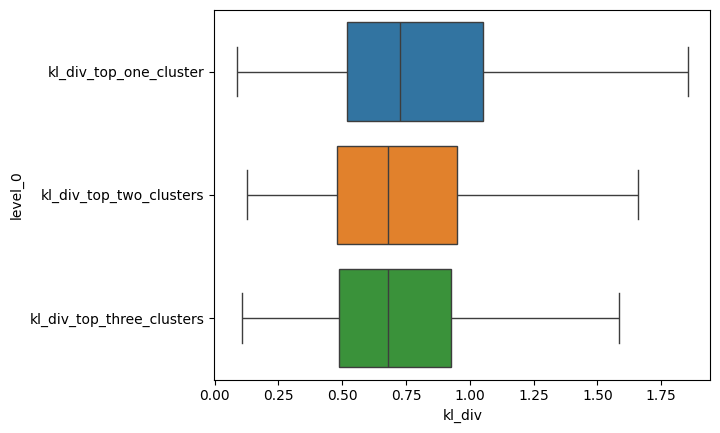

In [742]:
import seaborn as sns
(pd.concat([
    kl_div_1.to_frame('kl_div_top_one_cluster').reset_index(drop=True),
    kl_div_2.to_frame('kl_div_top_two_clusters').reset_index(drop=True),
    kl_div_3.to_frame('kl_div_top_three_clusters').reset_index(drop=True),
], axis=1)
 .unstack()
 .to_frame('kl_div')
 .reset_index()
 .pipe(lambda df: sns.boxplot(data=df, x='kl_div', y='level_0', hue='level_0', showfliers=False))
)

In [667]:
cluster_centers = (
    pd.DataFrame(
        clusterer.cluster_centers_, columns=col_dist)
     .pipe(lambda df: df.divide(df.sum(axis=1), axis=0)))
(cluster_centers
 .reset_index().rename(columns={'index':'cluster'})
).to_csv('../data/v3_clusters/cluster_centers.csv')

Text(0, 0.5, 'Proportion of Each Label')

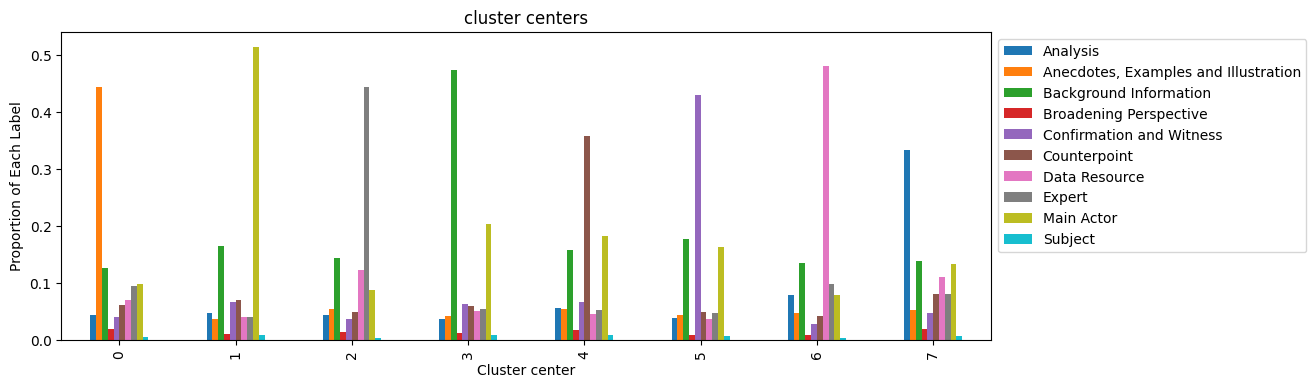

In [630]:
(pd.DataFrame(
    clusterer.cluster_centers_, columns=col_dist)
 .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
).plot(kind='bar', figsize=(12,4), title='cluster centers')

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Cluster center')
plt.ylabel('Proportion of Each Label')

In [663]:
(pd.DataFrame(
    clusterer.cluster_centers_, columns=col_dist)
 .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
 .pipe(lambda df: df * 100).astype(int)
 # .map(lambda x: f'{x}%')
 .apply(lambda s: ', '.join(list(map(lambda x: f'{x[0]}: {x[1]}%', s.sort_values(ascending=False).items()))), axis=1)
 .to_dict()
 # .iloc[0]
 # .pipe(lambda s: ', '.join(list(map(lambda x: f'{x[0]}: {x[1]}', s.sort_values(ascending=False).items()))))
 # .apply(lambda x: , axis=1)
 # .apply(lambda x:)
 # .reset_index().rename(columns={'index':'cluster'})
)

{0: 'Anecdotes, Examples and Illustration: 44%, Background Information: 12%, Expert: 9%, Main Actor: 9%, Data Resource: 7%, Counterpoint: 6%, Analysis: 4%, Confirmation and Witness: 3%, Broadening Perspective: 1%, Subject: 0%',
 1: 'Main Actor: 51%, Background Information: 16%, Confirmation and Witness: 6%, Counterpoint: 6%, Analysis: 4%, Data Resource: 4%, Expert: 4%, Anecdotes, Examples and Illustration: 3%, Broadening Perspective: 1%, Subject: 0%',
 2: 'Expert: 44%, Background Information: 14%, Data Resource: 12%, Main Actor: 8%, Anecdotes, Examples and Illustration: 5%, Analysis: 4%, Counterpoint: 4%, Confirmation and Witness: 3%, Broadening Perspective: 1%, Subject: 0%',
 3: 'Background Information: 47%, Main Actor: 20%, Confirmation and Witness: 6%, Counterpoint: 5%, Data Resource: 5%, Expert: 5%, Anecdotes, Examples and Illustration: 4%, Analysis: 3%, Broadening Perspective: 1%, Subject: 0%',
 4: 'Counterpoint: 35%, Main Actor: 18%, Background Information: 15%, Confirmation and 

### How many Sources have different roles?

In [487]:
output_with_queries = (
    llama_output
        .merge(prompts[['url', 'query', 'Name', 'Biography']], on=['url', 'Name'])
        .drop_duplicates()
)

In [421]:
url = label_distributions.assign(clusters=clusters).loc[lambda df: df['clusters'] == 1].index[25]

In [422]:
output_with_queries.loc[lambda df: df['url'] == url]['query'].iloc[0]

"Who will pay for the massive reconstruction of Ukraine's infrastructure, and how will the estimated $138 billion to $750 billion in costs be covered?"

### How many different roles do sources have if they're reused?

In [443]:
role_by_source = llama_output.groupby('Name')['llama_label'].aggregate(list)

In [468]:
from scipy.stats import entropy

# Function to calculate Gini Impurity for each datapoint
def label_variations(labels):
    label_counts = pd.Series(labels).value_counts()
    total = len(labels)
    # modified gini impurity
    impurity = 1 - sum((count / total) ** 2 for count in label_counts)
    # label inconsistency (1 - most_common_label / total_appearnaces)
    inconsistency = 1 - (label_counts.max() / total)
    # inconsistency = (label_counts.max() / total)
    # label entropy
    probabilities = label_counts / total
    e = entropy(probabilities, base=2)
    # label diversity 
    num_unique_labels = label_counts.shape[0]
    diversity = num_unique_labels / total
    return {'impurity': impurity, 'inconsistency': inconsistency, 'entropy': e, 'label_diversity': diversity}


In [469]:
label_stats = (
    role_by_source
         .loc[lambda s: s.str.len().pipe(lambda s: (s > 2) & (s < 10))]
         # .loc[lambda s: s.str.len().pipe(lambda s: (s > 2))]# & (s<20))]
         .to_frame('roles')
         .assign(num_usages=lambda df: df['roles'].str.len())
         .assign(num_distinct_usages=lambda df: df['roles'].apply(set).str.len())
         .assign(stats=lambda df: df['roles'].apply(label_variations))
    
)

In [470]:
label_stats['stats'].pipe(lambda s: pd.DataFrame(s.tolist())).mean()

impurity           0.410921
inconsistency      0.336263
entropy            0.958961
label_diversity    0.552601
dtype: float64

# Run TopicGPT on these Sources!

#### Imports

In [422]:
import pandas as pd 
import numpy as np 
import sys
sys.path.insert(0, '../make_source_label_hierarchy/')
import os
os.environ['OPENAI_API_KEY']=open('/Users/spangher/.openai-isi-project-key.txt').read().strip()
from utils_client import call_openai_completions
from tqdm.auto import tqdm
from sklearn.cluster import KMeans
import numpy as np 
import random

def decreasing_probability_sampling(n_total, k):
    output = []
    for i in range(1, n_total):
        prob = 1 / (i**k)
        r = random.random()
        if r < prob:
            output.append(i)
    return output

### Do the initial setup

In [453]:
source_df_with_clusters = pd.read_csv('../data/v3_sources/v3_source_with_clusters.csv.gz', index_col=0)
cluster_centers = np.load('../data/v3_sources/v3_embeddings__from_trained_model.npz')['arr_0']
cluster_df = pd.DataFrame(cluster_centers).assign(cluster_center=source_df_with_clusters['clusters'].values)

In [420]:
cluster_df = (
    cluster_df
         .groupby('cluster_center')
         .mean()
)

In [410]:
LEAF_NODE_PROMPT = """
You are a helpful assistant. I will give you a large set of labels I wrote down.

Here are the labels:

{labels}

Please summarize them with a single, specific label for the entire group. Be descriptive so I can really understand.
Please return just one label and one description. Make it in the same format as the input labels.
"""

In [413]:
groups = list(source_df_with_clusters.groupby('clusters')['Narrative Function'])
child_node_summaries = {}
for cluster_id, g in tqdm(groups):
    g = g.dropna()
    label_sample = g.sample(min(len(g), 50))
    summary_label = call_openai_completions(prompt=LEAF_NODE_PROMPT.format(labels='\n'.join(label_sample)))
    child_node_summaries[cluster_id] = summary_label

  0%|          | 0/1024 [00:00<?, ?it/s]

In [418]:
pd.Series(child_node_summaries).to_csv('cache/v3_child-node-summaries.txt', index=False)

### Run Hierarchical KMeans

In [436]:
from tqdm.auto import tqdm

In [434]:
bins = decreasing_probability_sampling(1024, .9)
bins = [1, 2, 4, 6, 10, 35, 84]

In [429]:
INNER_NODE_PROMPT_KMEANS = """
You are a helpful assistant. I will give you a list of labels I wrote.

Here are the labels:

{labels}

Please condense them into a single, specific label, focusing on their commonalities. 
Focus on the narrative role of the source, less on specific industries or topics they might cover. 
Try to avoid using the word "narrative" unless necessary.
Please return just one 2-3 word label and one description. Make it in the same format as the input labels.
"""

In [433]:
cluster_centers = cluster_df.values

In [435]:
clustering_rounds = {}
intermediate_node_summaries = child_node_summaries
# cluster_centers = np.load('../make_source_label_hierarchy/models/kmeans-embs-output.txt')
# bins = [1, 3, 6, 15, 40]#, 150]

In [438]:
sample_weights = source_df_with_clusters['clusters'].value_counts().sort_index()
use_sample_weights = True
for bin_idx in reversed(bins):
    kmeans = KMeans(bin_idx)
    if use_sample_weights:
        labels = kmeans.fit_predict(cluster_centers, sample_weight=sample_weights)
        sample_weights = (
            sample_weights
                 .to_frame('old_sample_weights').assign(parent_cluster=kmeans.labels_)
                 .reset_index(drop=True)
                 .groupby('parent_cluster')['old_sample_weights'].sum()
        )
    else:
        labels = kmeans.fit_predict(cluster_centers)
    
    inter_summ = (
        pd.Series(intermediate_node_summaries)
            .to_frame('cluster_description')
            .reset_index()
            .rename(columns={'index': 'child_cluster'})
    )
    inter_summ['parent_cluster'] = kmeans.labels_
    clustering_rounds[bin_idx] = inter_summ.copy()
    groups = list(inter_summ.groupby('parent_cluster')['cluster_description'])
    intermediate_node_summaries = {}
    for cluster_id, g in tqdm(groups):
        g = g.dropna()
        label_sample = g.sample(min(len(g), 50))
        summary_label = call_openai_completions(prompt=INNER_NODE_PROMPT_KMEANS.format(labels='\n'.join(label_sample)))
        intermediate_node_summaries[cluster_id] = summary_label

    cluster_centers = kmeans.cluster_centers_

inter_summ = pd.Series(intermediate_node_summaries).to_frame('cluster_description').reset_index().rename(columns={'index': 'child_cluster'})
clustering_rounds[0] = inter_summ.copy()

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Group and interpret the tree

In [439]:
sorted_keys = sorted(clustering_rounds.keys(), key=lambda x: -x)

## zero_out, for sanity
for c in clustering_rounds.values():
    c['parent_round'] = np.nan
    c['current_round'] = np.nan
    c['child_round'] = np.nan

for child_round, parent_round in zip(sorted_keys[:-1], sorted_keys[1:]):
    child_df = clustering_rounds[child_round]
    child_df['parent_round'] = parent_round
    child_df['current_round'] = child_round
    # 
    parent_df = clustering_rounds[parent_round]
    parent_df['child_round'] = child_round
    parent_df['current_round'] = parent_round

all_clusters = pd.concat(list(map(lambda i: clustering_rounds[i], sorted_keys)))
all_clusters = all_clusters.rename(columns={
    'child_cluster': 'node_idx',
    'cluster_description': 'node_description',
    'parent_cluster': 'parent_idx',
    'parent_round': 'parent_tree_level',
    'current_round': 'node_tree_level',
    'child_round': 'child_tree_level'
}) #.loc[lambda df: df['parent_round'].isnull()]

In [440]:
import utils_tree as ut
from collections import defaultdict
def build_parent_lists():
    parent_lists = []
    leaf_nodes = all_clusters.loc[lambda df: df['child_tree_level'].isnull()]
    for node_id, row in tqdm(leaf_nodes.iterrows(), total=len(leaf_nodes)):
        running_list = []
        running_list.append(row['node_description'])
        while True:
            row = (all_clusters
                       .loc[lambda df: df['node_tree_level'] == row['parent_tree_level']]
                       .loc[row['parent_idx']]
                  )
            running_list.append(row['node_description'])
            if pd.isnull(row['parent_tree_level']):
                break
        parent_lists.append(running_list)
    return parent_lists

def build_rooted_tree(text_processing_function=None):
    tree = {}
    # all_clusters.loc[lambda df: df['parent_tree_level'].isnull()].iloc[0]
    old_parent_children = defaultdict(list)
    curr_parent_children = defaultdict(list)
    curr_nodes = all_clusters.loc[lambda df: df['child_tree_level'].isnull()]
    while True:
        for node_id, row in curr_nodes.iterrows():
            p_idx = row['parent_idx'] if pd.notnull(row['parent_idx']) else 'root'
            node_desc = row['node_description'] if text_processing_function is None else text_processing_function(row['node_description'])
            curr_parent_children[p_idx].append({
                "node": node_desc,
                "children": old_parent_children.get(row['node_idx'])
            })
        old_parent_children = curr_parent_children
        curr_parent_children = defaultdict(list)
        if curr_nodes['parent_tree_level'].isnull().any():
            break
        curr_nodes = all_clusters.loc[lambda df: df['node_tree_level'] == row['parent_tree_level']]
    return old_parent_children['root'][0]

In [441]:
t = build_rooted_tree(text_processing_function=lambda x: x.split(':')[0].split('\n\n')[0])

In [442]:
import networkx as nx

def build_networkx_graph(d, G=None, parent=None, depth=0):
    if G is None:
        G = nx.DiGraph()  # You can use nx.Graph() if the graph is undirected

    node_label = f"{d.get('node')}-{depth}"
    if node_label is None:
        return G  # If there's no node, nothing to add

    # Add the node with the 'description' attribute
    G.add_node(node_label, description=node_label)

    if parent is not None:
        # Add an edge from the parent to this node
        G.add_edge(parent, node_label)

    children = d.get('children', [])
    if children:
        for child in children:
            if child:  # Ensure child is not None
                build_networkx_graph(child, G, parent=node_label, depth=depth+1)

    return G

In [443]:
G = build_networkx_graph(t)

In [447]:
from adjustText import adjust_text
# Specify the desired depth
desired_depth = 5  # Change this to your desired depth
# Compute the shortest path lengths from the root node to all other nodes
depths = nx.single_source_shortest_path_length(G, f"{t['node']}-{0}")
nodes_within_depth = [node for node, depth in depths.items() if depth <= desired_depth]
G_sub = G.subgraph(nodes_within_depth)

### The tree

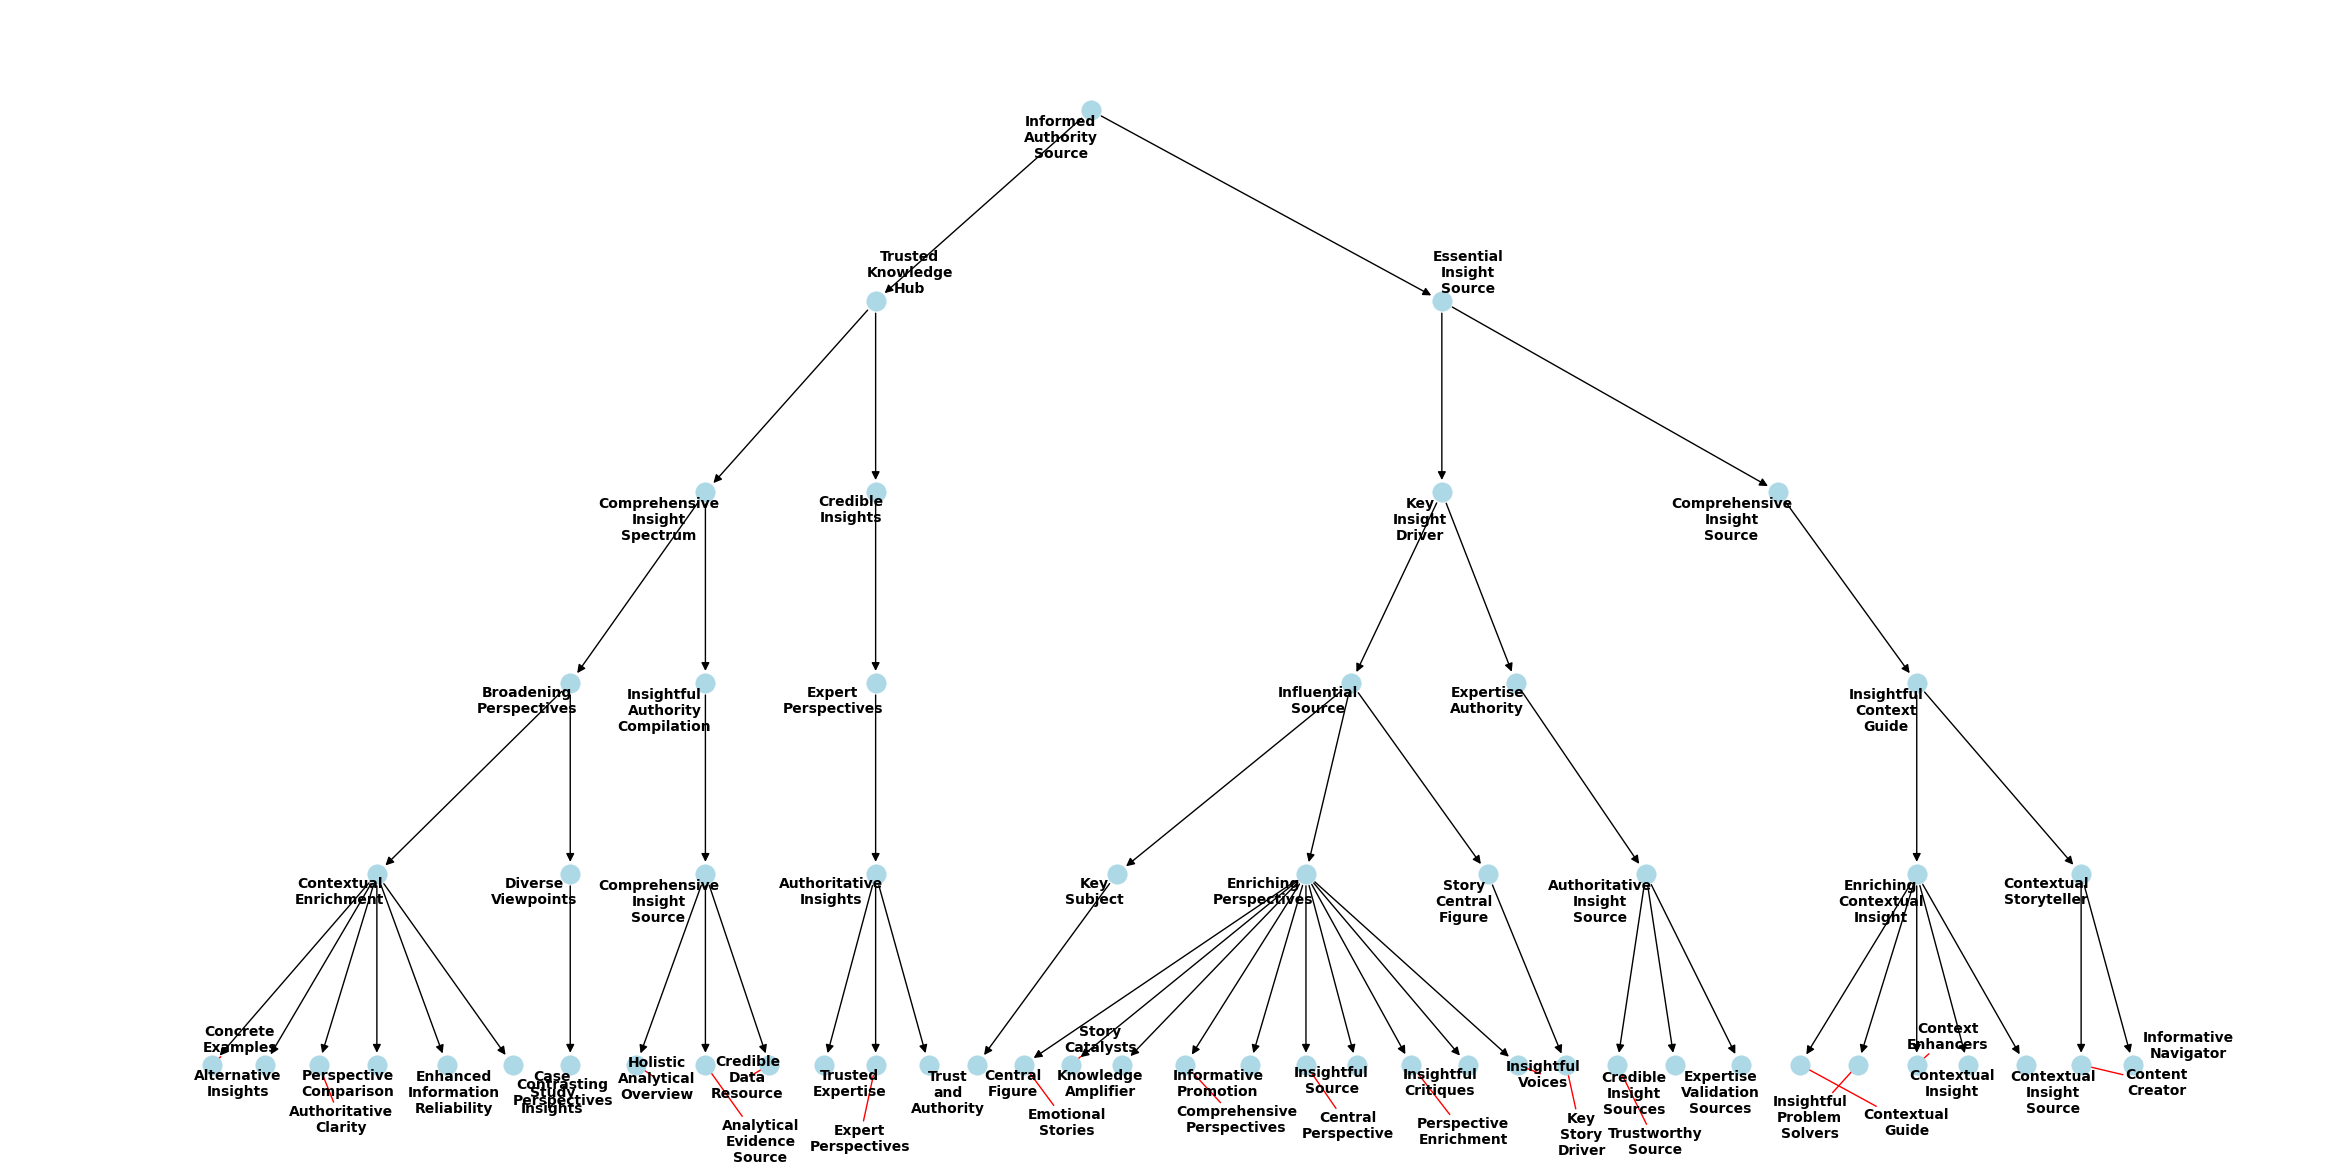

In [448]:
import re 
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 15))

# Compute the positions for the nodes using hierarchy_pos
pos = nx.drawing.nx_agraph.graphviz_layout(G_sub, prog="dot")

nx.draw_networkx_edges(G_sub, pos, arrows=True, arrowstyle='-|>', arrowsize=12)
nx.draw_networkx_nodes(G_sub, pos, node_size=200, node_color='lightblue', linewidths=0.25)

# Prepare the texts for adjustment
labels = nx.get_node_attributes(G_sub, 'description')
texts = []
for node, (x, y) in pos.items():
    text = plt.text(x, y, re.split(r'-\d', labels[node])[0].replace(' ', '\n').replace('"', ''), fontsize=10, fontweight='bold', ha='center', va='center')
    texts.append(text)

# Adjust the texts to minimize overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', ))

# Draw the tree
# nx.draw(G_sub, pos, with_labels=True, node_size=70, node_color="skyblue", font_size=6)
plt.axis('off')
plt.show()

In [461]:
list(enumerate(bins))

[(0, 84), (1, 35), (2, 10), (3, 6), (4, 4), (5, 2), (6, 1), (7, 0)]

In [472]:
bins=list(clustering_rounds.keys())
# for i, b in enumerate(bins):
source_df_with_clusters_t = (
    source_df_with_clusters
         .drop(columns=['Is_Error', 'Unnamed: 0'])
         .merge(clustering_rounds[bins[0]][['child_cluster', 'cluster_description', 'parent_cluster']], right_on='child_cluster', left_on='clusters')
         .drop(columns=['child_cluster', 'clusters']).rename(columns={'cluster_description': 'cluster_descript_leaf_1'})
)
for i in range(1, 7):
    source_df_with_clusters_t = (
        source_df_with_clusters_t
         .merge(clustering_rounds[bins[i]][['child_cluster', 'cluster_description', 'parent_cluster']], right_on='child_cluster', left_on='parent_cluster')
         .drop(columns=['child_cluster', 'parent_cluster_x']).rename(columns={'cluster_description': f'cluster_descript_leaf_{i+1}', 'parent_cluster_y': 'parent_cluster'})
    )

In [473]:
source_df_with_clusters_t = (
    source_df_with_clusters_t
    .merge(clustering_rounds[bins[-2]][['child_cluster', 'cluster_description', 'parent_cluster']], right_on='child_cluster', left_on='parent_cluster')
         .drop(columns=['child_cluster', 'parent_cluster_x']).rename(columns={'cluster_description': 'cluster_descript_leaf_8', 'parent_cluster_y': 'parent_cluster'}) 
         .drop(columns=['parent_cluster'])
)

In [478]:
source_df_with_clusters_t[['cluster_descript_leaf_4', 'cluster_descript_leaf_5', 'cluster_descript_leaf_6']] = source_df_with_clusters_t[['cluster_descript_leaf_4', 'cluster_descript_leaf_5', 'cluster_descript_leaf_6']].apply(lambda s: s.str.split(':').str.get(0))

In [480]:
source_df_with_clusters_t['cluster_descript_leaf_4'].value_counts()

cluster_descript_leaf_4
"Enriching Perspectives"          124309
"Contextual Enrichment"            72720
"Enriching Contextual Insight"     62944
"Authoritative Insight Source"     58423
"Authoritative Insights"           45365
"Comprehensive Insight Source"     32297
"Contextual Storyteller"           21854
"Story Central Figure"             20784
"Diverse Viewpoints"               12742
"Key Subject"                       8852
Name: count, dtype: int64

In [486]:
source_df_with_clusters_t['Narrative Function'].iloc[0]#.loc[lambda df: df['cluster_descript_leaf_4'] == '"Key Subject"']

'"Critic": This source is used to provide a critical perspective on Google\'s practices and highlight the negative impact of the algorithm on small businesses.'